# Import libraries and modules

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1e-3
integrator_keywords['atol'] = 1e-6

# Functions

In [2]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

# Load data

In [3]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)
system_size = 20
n_samples = 5000

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

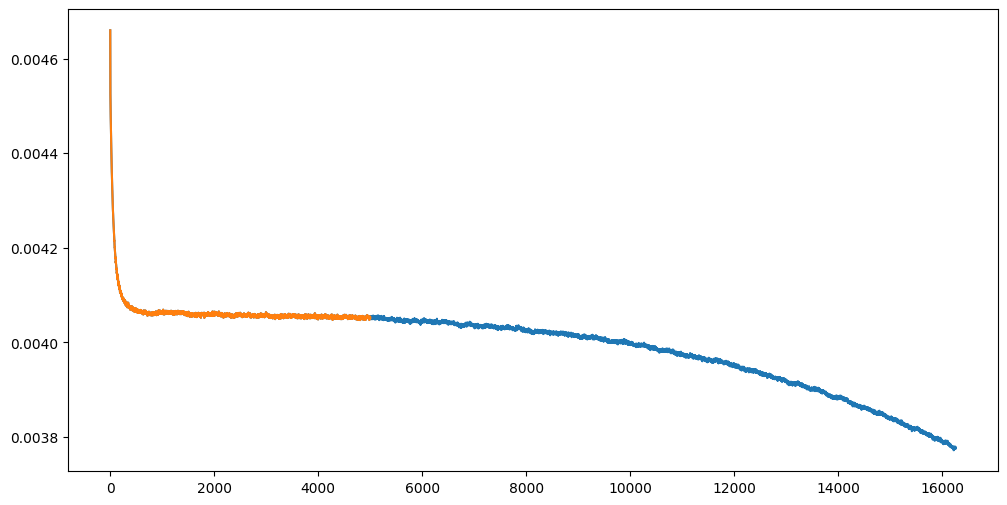

In [4]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values[:n_samples], N_clusters[:n_samples, n_to_plot-1], label=f'Cluster size {n_to_plot}')

# Build and fit the model

In [5]:
# Fit the model

poly_order = 2
threshold = 1e-10
dt = 1

model = ps.SINDy( 
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(N_clusters[:n_samples], t=dt)
model.print()

(x0)' = 0.042 1 + -18.616 x0 + 35.359 x1 + -381.098 x2 + 58.587 x3 + 95.269 x4 + -0.474 x5 + -0.816 x6 + 0.242 x7 + -0.746 x8 + 0.268 x9 + 3.364 x10 + 0.769 x11 + 0.448 x12 + 3.993 x13 + -1.328 x14 + 2.890 x15 + -1.156 x16 + 2.982 x17 + 0.699 x18 + 5.593 x19 + 1987.037 x0^2 + -3811.400 x0 x1 + 71845.687 x0 x2 + -14406.020 x0 x3 + -23425.969 x0 x4 + -52904.495 x1^2 + 269140.937 x1 x2
(x1)' = 0.052 1 + -18.591 x0 + -88.899 x1 + 18.799 x2 + -10.684 x3 + 0.267 x4 + 0.789 x5 + 1.058 x6 + 0.827 x7 + 1.216 x8 + 0.728 x9 + -0.954 x10 + -0.040 x11 + 0.076 x12 + -0.878 x13 + 1651.478 x0^2 + 16279.109 x0 x1 + -4618.651 x0 x2 + 2654.945 x0 x3 + 34329.876 x1^2
(x2)' = -0.001 1 + 0.443 x0 + 1.105 x1 + -1.212 x2 + -0.045 x3 + -0.069 x4 + -0.054 x5 + 0.033 x6 + 0.031 x7 + 0.240 x8 + 0.271 x9 + -45.450 x0^2 + -271.286 x0 x1 + 292.564 x0 x2
(x3)' = -0.019 x0 + 0.003 x1 + -0.004 x2 + -0.006 x3 + -0.018 x4 + -0.012 x5 + 0.009 x6 + 2.327 x0^2
(x4)' = -0.008 x0 + 0.002 x1 + -0.003 x2 + -0.003 x3 + -0.008 x4

In [6]:
n_sim = model.simulate(N_clusters[0], t=t_values, integrator_kws=integrator_keywords)

/tmp/ipykernel_181835/1994608317.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)


Cluster size 50 is larger than the system size 20
Cluster size 100 is larger than the system size 20


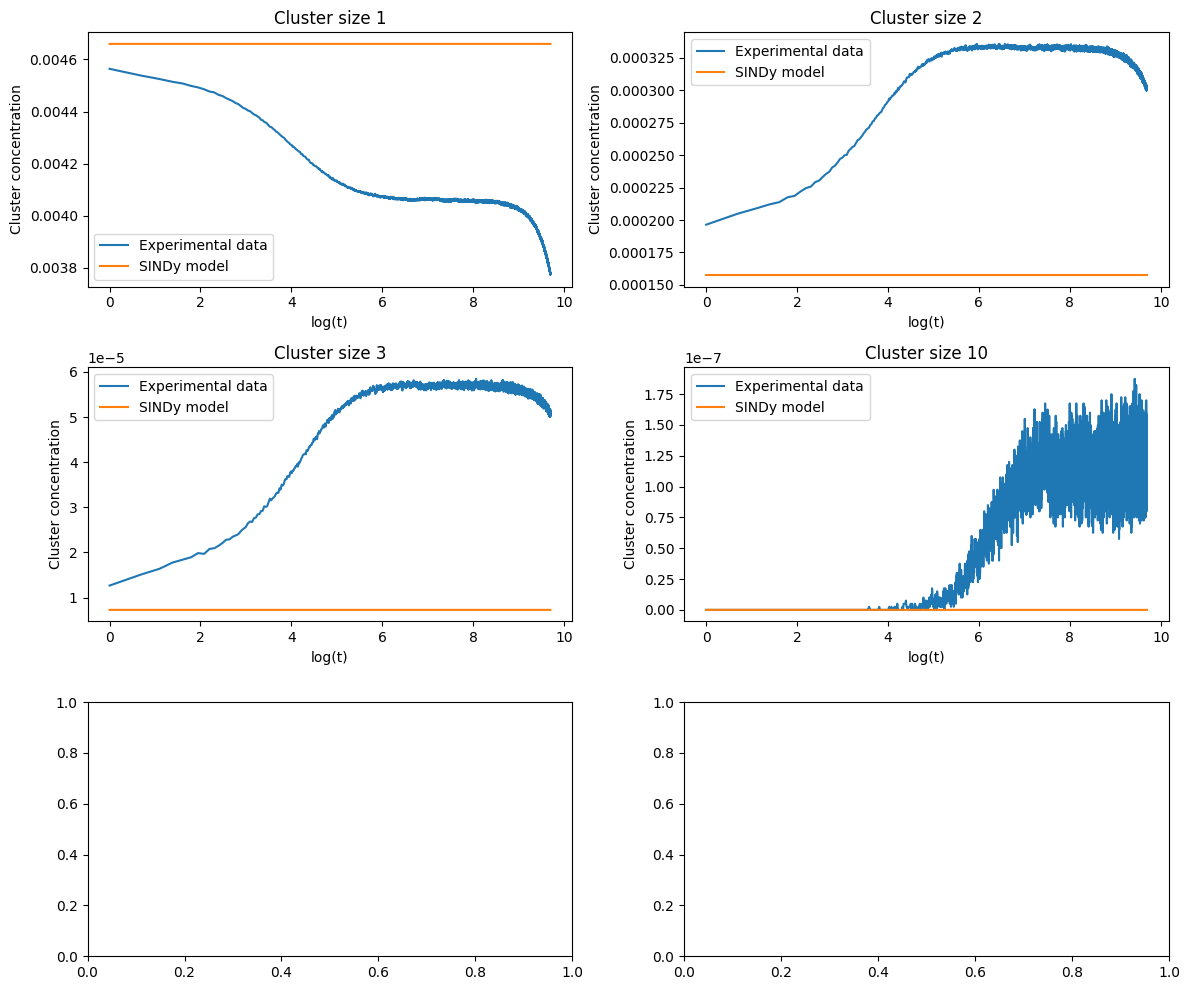

In [ ]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_values_log, n_sim[:, n_to_plot-1], label='SINDy model')
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()